# Comparing Classification Models

## Business Context
A Portuguese banking institution was conducting a telemarketing campaign to solicit new business for its Term Deposit products. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required.  

## Research Objectives
The institution compiled over 40,000 records encompassing a wide array of attributes, including demographic information, details of previous customer interactions, and macroeconomic indicators. This exploratory data analysis and research aims to leverage the information to improve the bank's telemarketing strategies for promoting Term Deposit products.

<a id='dictionary'></a>
### Data Dictionary
#### Bank client data:
- **age**: Age of the customer
- **job**: type of job ("admin.", "bluecollar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")
- **marital**: marital status ("divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
- **education** ("basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
- **default**: has credit in default? ("no", "yes", "unknown")
- **housing**: has housing loan? ("no", "yes", "unknown")
- **loan**: has personal loan? ("no", "yes", "unknown")
#### Related to the Last Contact of the Current Campaign:
- **contact**: contact communication type ("cellular", "telephone") 
- **duration**: last contact duration, in seconds. **Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no")**. Yet, the duration is not known before a call is performed. Also, after the end of the call `y` is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- **campaign**: number of contacts performed during this campaign and for this client (includes last contact)
- **month**: last contact month of year ("jan", "feb", "mar", ..., "dec")
- **day_of_week**: last contact day of the week ("mon", "tue", "wed", "thu", "fri")
#### Related the the Previous Campaign:
- **pdays**: number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)
- **previous**: number of contacts performed before this campaign and for this client
- **poutcome**: outcome of the previous marketing campaign ("failure","nonexistent","success")
#### Social and economic context attributes
- **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
- **cons.price.idx**: consumer price index - monthly indicator (numeric)     
- **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)     
- **euribor3m**: euribor 3 month rate - daily indicator (numeric)
- **nr.employed**: number of employees - quarterly indicator (numeric)

####  Output variable (desired target):
- **y** - has the client subscribed to a Term Deposit? ("yes", "no")

#### Missing Values: 
There are several missing values in some categorical attributes, all coded with the "unknown" label. 


[Loading Data](#load_data) ||
[Data Exploration](#explore_data) || [Preprocessing and Transformation](#transform_data) ||
[Modeling](#model) ||

## Technical Implementation

In [65]:
import numpy as np
import pandas as pd

# Graphical Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing and Feature Selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer

# Metrics and Feature Importance
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

[Loading Data](#load_data) ||
[Data Exploration](#explore_data) ||
[Modeling](#model) ||


<a id='class_definition'></a>
## EDA Utilities

In [66]:
# Custom Exploratory Data Analysis utility class
#   author       = {Chihming Chen},
#   title        = {{Exploratory Data Analysis Utilities}},
#   year         = {2023}
#   version      = {1.0}

class EDA:
    import pandas as pd
    import re
      
    def __init__(self, df, path=None):
        self._df = df
        self._path = path

    @property
    def df(self):
        return self._df

    @df.setter
    def df(self, new_df):
        self._df = new_df   
    
    def reload(self):
        if self._path:
            self._df = pd.read_csv(self._path)
        else:
            raise ValueError("No path specified for reloading.")
        
        return self._df
        
    def column_null_stats(self, subset=None, null_only=True) -> pd.DataFrame:
        """" Calculate the null counts and percentage of total per column"""
        if subset:
            null_counts = self._df[subset].isna().sum()
        else:
            null_counts = self._df.isna().sum()

        # Calculate the percentage of null values per column
        total_rows = self._df.shape[0]
        null_percentages = (null_counts / total_rows) * 100

        # Get data types of columns in the DataFrame
        column_dtype = self._df.dtypes

        # Create a new DataFrame to display null counts, column data types, and percentage of total rows
        null_info = pd.DataFrame({
            'null count': null_counts,
            'pct_total': round(null_percentages, 2),
            'dtype': column_dtype  
        })
        if null_only:
            # Return stats of columns with missing values
            null_info = null_info.query("pct_total > 0").sort_values('pct_total', ascending=False)
        else:
            # Return stats of entire subset
            null_info = null_info.sort_values('pct_total', ascending=False)
        
        return null_info

    
    def row_null_stats(self, subset=None) -> pd.DataFrame:
        # Count the number of null values in each row
        total_rows = self._df.shape[0]
        if subset:
            self._df['_num_nulls'] = self._df[subset].isnull().sum(axis=1)
        else:
            self._df['_num_nulls'] = self._df.isnull().sum(axis=1)
        row_null_counts = self._df.groupby('_num_nulls')['_num_nulls'].count().sort_index(ascending=False)
        cumulative_sum = np.cumsum(row_null_counts)
        cumulative_pct = cumulative_sum / total_rows * 100

        row_null_stats = pd.DataFrame({
        'num_null': row_null_counts.index,     
        'count': row_null_counts,
        'pct_total': round(row_null_counts / total_rows * 100, 4),
        'cum_pct': round(cumulative_pct, 4)     
        })
        
        row_null_stats.set_index('num_null', inplace=True)
        self._df.drop(columns=['_num_nulls'], inplace=True)
        return row_null_stats
    
    def categorical_features(self, null_only=False) -> list:
        # Extract columns with 'object' dtype (assumed categorical)
        categorical_columns = set(self._df.select_dtypes(exclude=['number']).columns.tolist())
        
        if null_only:
            # Obtain the columns with null statistics (assuming column_null_stats returns a DataFrame)
            null_stats_columns = set(self.column_null_stats.index.tolist())
            categorical_columns = list(categorical_columns.intersection(null_stats_columns))

        return list(categorical_columns)
    
    def categorical_value_counts(self, normalize=True, rounding=2):
        categrical_columns = self.categorical_features()
        for col in categrical_columns:
            value_counts = self._df[col].value_counts()
            if normalize:
                value_counts = value_counts / self._df.shape[0] * 100
                value_counts = value_counts.round(rounding).astype(str) + '%'                
            print(value_counts, '\n')
            
    def numeric_features(self) -> list:
            numeric_cols = self._df.select_dtypes(include=['number']).columns.tolist()
            return numeric_cols
        
    def fillna(self, value=None):
        """Fill NaN with the value in all categorical features.
        If no `value` is given, fill with 'UNKNOWN_'
        """
        if value is None:
            value = 'UNKNOWN_'
        # Get the list of categorical columns with missing values 
        categorical_columns = self.categorical_features(null_only=True)
        # Fill missing values in the specified categorical columns with variable`value`
        self._df.loc[:, categorical_columns] = self._df[categorical_columns].fillna(value)

    def replace_all(self, to_replace, value):
        """ Search the term, to_replace, and replace it with the value in all string-like columns of a dataframe."""
        matching_cols = [
            col for col in self._df.columns
            if (self._df[col].dtype == 'object' or pd.api.types.is_string_dtype(self._df[col]))
            and to_replace in col
        ]

        if matching_cols:
            self._df.loc[:, matching_cols] = self._df.loc[:, matching_cols].replace(to_replace, value)

        return matching_cols

    def drop_marginal_row(self, pct_threshold=1, exclude=None) -> pd.DataFrame:
        column_stats = self.column_null_stats()
        columns_under_threshold = column_stats[column_stats['pct_total'] <= pct_threshold].index.tolist()
        if exclude:
            columns_to_drop = [col for col in columns_under_threshold if col not in exclude]
        else:
            columns_to_drop = columns_under_threshold
        self._df.dropna(subset=columns_to_drop, inplace=True)
        return self._df
    
        # Sort null_info by 'pct_total' in ascending order
        null_info = null_info.sort_values('pct_total')

        return null_info.query("pct_total > 0")

    def one_standing_encode(self, column, keep, name=None, drop=False):
        """ A variant of One-hot encoding. 
        Set the value in the new column to 1 if it is equal to the specified keep value.
        Set to 0, otherwise. name is the one-standing column name. If drop=True, the original column will be dropped.
        """
        if not name: # No name provided. Use default naming convention 
            rename_to = 'is_' + keep + '_' + column
        self._df[name] = (self._df[column] == keep).astype(int)
        
        if drop: # Drop the original column
            self._df.drop(columns=column, inplace=True)
        
    def regex_to_numeric(self, columns, fillna=None, regex=None):
        """ 
        Extract and set the numbers from the column values using regular expressions.
        If no regex is given, the default is to find the first occurrence of digits.
        """
        # If a single column name is provided, convert it to a list
        if not isinstance(columns, list):
            columns = [columns]
        
        for col in columns:
            # Check if the column has string values before using .str accessor
            if self._df[col].dtype in ['object', 'str', 'string', 'category']:
                # If no regex is given, find the first occurrence of digits
                if not regex: 
                    regex = r'(\d+)'
                self._df[col] = self._df[col].astype(str).str.extract(regex).astype(float)
                if fillna:
                    if fillna == 'mean':
                        self._df[col].fillna(self._df[col].mean)
                    else:
                        raise ValueError("Only fillna with 'mean' is supported.")

        
    def fillna_with_mean(self, exclude=None):
        # If exclude is not specified, fill NaN with mean for all numeric columns
        if exclude is None:
            numeric_columns = self._df.select_dtypes(include=[np.number]).columns
            columns_to_fill = [
                col for col in numeric_columns if not self._df[col].apply(lambda x: isinstance(x, str)).any()
            ]
            self._df[columns_to_fill] = self._df[columns_to_fill].fillna(self._df.mean())
        else:
            # Fill NaN with mean for numeric columns except those specified in 'exclude'
            columns_to_fill = [
                col for col in self._df.columns if col not in exclude and np.issubdtype(self._df[col].dtype, np.number)
            ]
            fill_values = self._df[columns_to_fill].mean()
            self._df[columns_to_fill] = self._df[columns_to_fill].fillna(fill_values)

    def target_binning(self, feature, target, n_bins, fillna=None):
        """ A variant of Target Encoding. 
        Binning the categorical values, into n_bins bins, based on
        the min and max means of the target of each categorical group.
        The group with the min(means) is set to the min(means) value.
        The group with the max(means) is set to the max(means) value.
        The range between min(means) and max(means) is equally cut into (n_bins - 1) intervals.
        """
        # Pre-fill missing values in the feature if specified
        if fillna:
            self._df[feature].fillna(fillna, inplace=True)
        else:
            # missing values are not filled and their ratings will be NaN
            pass
                       
        # Calculate the mean target values of individual feature values
        means = self._df.groupby(feature)[target].mean()
        # Get min, max to determine the range to be divided by n_bins
        min_, mean_, max_ = means.min(), means.mean(), means.max()
        # Divide the (min, max) range equally
        step = (max_ - min_) / (n_bins - 1)

        # Create bins based on means. the first bin label is _min, then steps up until, _max
        labels = [(min_ + i * step) for i in range(n_bins)]
        ratings = pd.cut(means, bins=n_bins, labels=labels, right=True, include_lowest=True).to_frame()

        ratings.reset_index(inplace=True)
        encoded_column_name = feature + '_rating'
        ratings.rename(columns={target: (encoded_column_name)}, inplace=True)

        # Create a new column and initialize it with NaN values
        self._df[encoded_column_name] = np.nan

        # Assign ratings based on feature values
        for index, row in ratings.iterrows():
            rating = row[encoded_column_name]
            feature_value = row[feature]
            self._df.loc[self._df[feature] == feature_value, encoded_column_name] = rating     
        
        # Convert the encoded column to int if no missing values
        if self._df[encoded_column_name].isna().sum() == 0: 
            self._df[encoded_column_name] = self._df[encoded_column_name].astype(int)   
            
        # Construct a mapping of ratings to lists of feature values
        rating_mapping = {}
        for index, row in ratings.iterrows():
            rating = row[encoded_column_name]
            feature_value = row[feature]
            if rating not in rating_mapping:
                rating_mapping[rating] = [feature_value]
            else:
                rating_mapping[rating].append(feature_value)
        sorted_keys = sorted(rating_mapping.keys(), reverse=True)  # Sort the keys
        sorted_rating_mapping = {key: rating_mapping[key] for key in sorted_keys}
        return sorted_rating_mapping
            
    def b4_aft(self, command, rounding=2):
        """Execute the command and print out the stats of affected rows.
        Use literal values in the command if the command takes arguments. 
        Variables are not evaludated and cannot be used as arguments.
        """
        shape_before = self._df.shape
        results = exec(command)
        shape_after = self._df.shape
        row_diff =  shape_before[0] - shape_after[0] 
        col_diff =  shape_before[1] - shape_after[1]
        if shape_before != shape_after:
            print(f'Dataset shape changed: {shape_before} -> {shape_after}')
            if row_diff > 0:
                print(f'{row_diff:,} of {shape_before[0]:,} rows, {round(100 * row_diff/shape_before[0], rounding)}%, dropped.')    
        return results

    def before_after_exec(self, command, dataframe=None, rounding=2):
        """Execute the command and print out the stats of affected dataframe.
        Literal referrence to 'df' is treated as calling by reference and the external df dataframe will be updated.
        """
        exec_globals = {dataframe: self._df}
        shape_before = self._df.shape
        results = exec(command, exec_globals)
        shape_after = self._df.shape
        row_diff =  shape_before[0] - shape_after[0] 
        col_diff =  shape_before[1] - shape_after[1]
        if shape_before != shape_after:
            print(f'Dataset shape changed: {shape_before} -> {shape_after}')
            if row_diff > 0:
                print(f'{row_diff:,} of {shape_before[0]:,} rows, {round(100 * row_diff/shape_before[0], rounding)}%, dropped.')    
        # Check if the dataframe variable has been assigned in the executed command
        if dataframe in exec_globals:
            self._df = exec_globals[dataframe]
            # Update the external dataframe
            globals()[dataframe] = self._df
        return results
    
    def performance_metrics(self, y, y_hat, n_features=None):
        """ Returns R2, Adj. R2, MSE, RMSE, MAE, MAPE scores as a dict. AdR2 Adj is returned on if n_features is provided.
            y are the actual target values, y_hat are the predicted values
        """
        metrics = {}
        metrics['R2'] = r2_score(y, y_hat)        
        if isinstance(n_features, int): # Calculate Adj. R-squared
            n = len(y)
            k = n_features # Number of predictors
            metrics['Adj. R2'] = 1 - (1 - metrics['R2']) * (n - 1) / (n - k - 1)
        
        metrics['MSE'] = mean_squared_error(y, y_hat)
        metrics['RMSE'] = np.sqrt(mean_squared_error(y, y_hat))
        metrics['MAE'] = mean_absolute_error(y, y_hat)
        metrics['MAPE'] = mean_absolute_percentage_error(y, y_hat)
        
        return metrics

|| [EDA Utilities](#class_definition) ||
[Data Dictionary](#dictionary) || 
[Data Exploration](#explore_data) ||
[Preprocessing](#transform_data) ||
[Modeling](#model) ||

<a id='load_data'></a>
## Loading Data

In [67]:
csv_data_file =  'data/bank-additional-full.csv'
df = pd.read_csv(csv_data_file, sep = ';')
print(f'Dataset dimensions as loaded: {df.shape}')
df.drop_duplicates(inplace=True)
print(f'Datase dimensions after dropping duplicates: {df.shape}')
# Use a custom Data Exploration Analysis utilties
eda = EDA(df, csv_data_file)

Dataset dimensions as loaded: (41188, 21)
Datase dimensions after dropping duplicates: (41176, 21)


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

||
[Data Dictionary](#dictionary) || 
[Loading Data](#load_data) ||
[Data Exploration](#explore_data) ||
[Preprocessing](#transform_data) ||
[Modeling](#model) ||

<a id='explore_data'></a>
## Data Exploration
### Missing Values and Treatments

#### Reverting Existing Missing Value Treatments
 - Some columns have missing values filled with 'unknown'
 - The `pdays` column is filled with 999 if the value is unknown
 - Reverting these treatments to explore options for final missing value treatments. e.g. Deletion, imputation, or keeping as categorical values.

In [69]:
# Revert existing missing value treatments?
revert_treatment = True
# Identify missing value treatments
na_fillers = ['unknown'] # 'other', 'missing', 'Not Available'

print(f"Existing missing value filler(s): {na_fillers}\n")
# Finding columns that contain any of the na treatments
if subset := [col for col in df.columns if df[col].isin(na_fillers).any()]:
    print('Columns containing missing value treatments:\n', subset)
# Strip whitespace
df.loc[:, subset] = df.loc[:, subset].apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

if revert_treatment:
    # Repalce fillers with NaN
    for filler in na_fillers:
        df.loc[:, subset] = df.loc[:, subset].replace(filler, np.nan)
    print("\nMissing value treatments reverted.")
else:
    print("\nMissing value treatments are kept as categories.")
na_treated_columns = subset

Existing missing value filler(s): ['unknown']

Columns containing missing value treatments:
 ['job', 'marital', 'education', 'default', 'housing', 'loan']

Missing value treatments reverted.


#### Columns with Missing Values

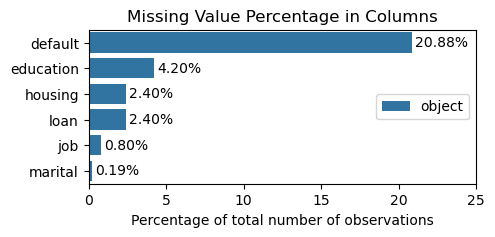

           null count  pct_total   dtype
default          8596      20.88  object
education        1730       4.20  object
housing           990       2.40  object
loan              990       2.40  object
job               330       0.80  object
marital            80       0.19  object


In [70]:
eda_null_cols = eda.column_null_stats()

if not eda_null_cols.empty:
    # Plot params
    fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    sns.barplot(eda_null_cols, x='pct_total', y=eda_null_cols.index, hue='dtype')
    
    # Adding annotations
    for p in ax.patches:
        ax.text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2, 
                f'{p.get_width():.2f}%', 
                va='center')
        
    plt.legend(loc='center right')
    plt.title("Missing Value Percentage in Columns")
    plt.xlabel("Percentage of total number of observations")
#     plt.grid(axis='x')
    plt.xticks(range(0, 26, 5))
    plt.savefig('images/missing_value_pct_col.png', bbox_inches='tight')
    plt.show()
    print(eda_null_cols)
else:
    print("No missing values in any column.")

#### Density of Missing Data in Rows

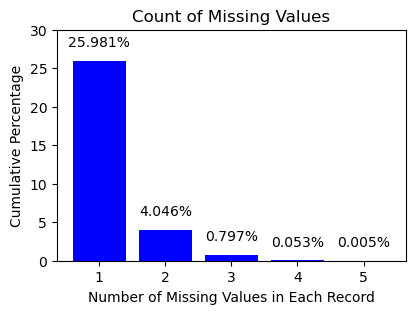

Cummulative number of missing values in records:

          count  pct_total   cum_pct
num_null                            
5             2     0.0049    0.0049
4            20     0.0486    0.0534
3           306     0.7432    0.7966
2          1338     3.2495    4.0460
1          9032    21.9351   25.9812
0         30478    74.0188  100.0000


In [71]:
# Stats of rows with missing values, indexed by number of nulls
eda_row_null_stats = eda.row_null_stats()
if not eda_null_cols.empty:
    # Plotting
    plot_data = eda_row_null_stats.query('cum_pct < 100')
    plt.figure(figsize=(4.5, 3))
    plt.bar(plot_data.index, plot_data['cum_pct'], color='b')
    for idx, value in plot_data['cum_pct'].items():
        plt.annotate(f'{value:.3f}%', (idx, value), textcoords="offset points", xytext=(0,10), ha='center')

    # Adding labels and title
    plt.title('Count of Missing Values')
    plt.xlabel('Number of Missing Values in Each Record')
    plt.ylabel('Cumulative Percentage')
    plt.xticks(range(1, 6))
    plt.yticks(range(0, 35, 5))
    plt.grid(False) 
    plt.savefig("images/row_missing_val_density.png", bbox_inches='tight')
    plt.show()
    print('Cummulative number of missing values in records:\n')
    print(eda_row_null_stats)
else:
    print('No missing values in any row.')

### Numeric / Categorical Features

In [72]:
# Counting numeric features vs. categorical features
if eda_numeric_features := eda.numeric_features():
    print(f'{len(eda_numeric_features)} numeric features:\n{eda_numeric_features}\n')
if eda_categorical_features := eda.categorical_features():
    print(f'{len(eda_categorical_features)} categorical features:\n{eda_categorical_features}')

# Convert object type to category type for non-numeric features
for feature in eda_categorical_features:
    df[feature] = df[feature].astype('category')

10 numeric features:
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

11 categorical features:
['education', 'job', 'housing', 'day_of_week', 'contact', 'default', 'y', 'month', 'marital', 'loan', 'poutcome']


### Unique Values of Categorical Features

In [73]:
eda.categorical_value_counts(rounding=2)

university.degree      29.54%
high.school             23.1%
basic.9y               14.68%
professional.course    12.73%
basic.4y               10.14%
basic.6y                5.56%
illiterate              0.04%
Name: education, dtype: object 

admin.            25.3%
blue-collar      22.47%
technician       16.37%
services          9.63%
management         7.1%
retired           4.17%
entrepreneur      3.54%
self-employed     3.45%
housemaid         2.57%
unemployed        2.46%
student           2.13%
Name: job, dtype: object 

yes    52.39%
no     45.21%
Name: housing, dtype: object 

thu    20.93%
mon    20.67%
wed    19.75%
tue    19.64%
fri    19.01%
Name: day_of_week, dtype: object 

cellular     63.47%
telephone    36.53%
Name: contact, dtype: object 

no     79.12%
yes     0.01%
Name: default, dtype: object 

no     88.73%
yes    11.27%
Name: y, dtype: object 

may    33.43%
jul    17.41%
aug     15.0%
jun    12.92%
nov     9.96%
apr     6.39%
oct     1.74%
sep     1.38%
mar    

### Observations on Categorical Values
 - 86% of records have the 'nonexistent' value in the `poutcome` column if the customer did not participate in previous telemarketing campaign.
 - No ordinal values in the categorical features except the `education` feature that can be converted to the number of years of education.

### Final Missing Value Treatments
- Fill missing values with 'uknown' as categorical values so that the model can predict new data with missing values
- Convert the data type from 'object' to 'category'

In [74]:
na_filler = 'unknown'
for col_ in eda_categorical_features:
    if df[col_].dtype.name == 'category':
        df[col_] = df[col_].astype('object').fillna(na_filler).astype('category')

[Loading Data](#load_data) ||
[Data Dictinoary](#dictionary) ||
[Data Exploration](#explore_data) ||
[Preprocessing & Transformation](#transform_data) ||
[Modeling](#model) ||

<a id='transform_data'></a>
## Data Preprocessing and Transformation

### The  `duration` Column
The duration of the last contact, in seconds. It is not unknown before a call to customer is made and is set to 0. In these cases, the target variable `y` is set to 'no'.  After the call is made, the target variable is set to either 'yes' or 'no' according to the result. **This missing value treatment strongly bias the classification. Therefore, the `duration` should be deleted if it has the  value zero or disregarded as input for predictive models.**

In [75]:
df.query("duration == 0")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6251,39,admin.,married,high.school,no,yes,no,telephone,may,tue,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
23031,59,management,married,university.degree,no,yes,no,cellular,aug,tue,...,10,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
28063,53,blue-collar,divorced,high.school,no,yes,no,cellular,apr,fri,...,3,999,0,nonexistent,-1.8,93.075,-47.1,1.479,5099.1,no
33015,31,blue-collar,married,basic.9y,no,no,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no


### Drop the `duration` Column

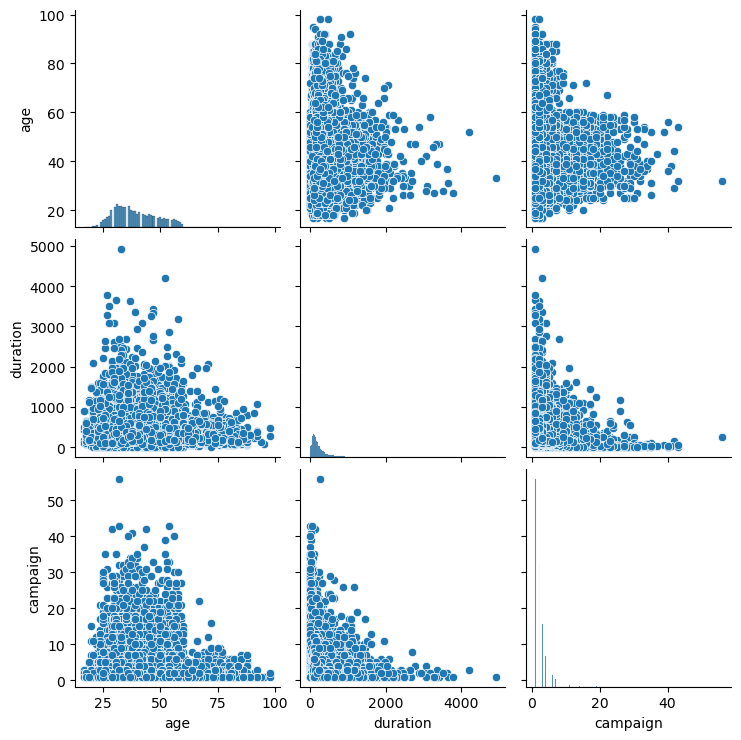

In [76]:
sns.pairplot(df[['age', 'duration', 'campaign']])

In [77]:
command = "df.drop(columns=['duration'], inplace=True)"
eda.before_after_exec(command, 'df')
# df = df[df['duration'] != 0]
# eda.df = df

Dataset shape changed: (41176, 21) -> (41176, 20)


### Check Data Integrity between `pdays` and `poutcome`
 - If a customer has never been contacted by telemarketing in the past, `pdays` should be 999 and `poutcome` should be 'nonexistent`, and vise versa.
 - 4,110 violations of this integrity rule are observed.

In [78]:
# Check data integraty
# Violation 1: 'pdays' is 999 but 'poutcome' is not 'nonexistent'
violation_1 = df[(df['pdays'] == 999) & (df['poutcome'] != 'nonexistent')]
# Violation 2: 'pdays' is not 999 but 'poutcome' is 'nonexistent'
violation_2 = df[(df['pdays'] != 999) & (df['poutcome'] == 'nonexistent')]

# Combine both violations
violations = pd.concat([violation_1, violation_2])
violations

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24013,38,blue-collar,single,unknown,no,yes,no,telephone,oct,tue,1,999,1,failure,-0.1,93.798,-40.4,4.968,5195.8,no
24019,40,services,married,high.school,no,yes,no,telephone,oct,tue,1,999,1,failure,-0.1,93.798,-40.4,4.968,5195.8,yes
24076,36,admin.,married,university.degree,no,yes,no,telephone,nov,wed,1,999,1,failure,-0.1,93.200,-42.0,4.663,5195.8,no
24102,36,admin.,married,high.school,no,yes,no,telephone,nov,wed,1,999,1,failure,-0.1,93.200,-42.0,4.286,5195.8,yes
24113,29,self-employed,married,university.degree,no,yes,no,telephone,nov,thu,1,999,1,failure,-0.1,93.200,-42.0,4.245,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41166,32,admin.,married,university.degree,no,no,no,telephone,nov,wed,1,999,1,failure,-1.1,94.767,-50.8,1.030,4963.6,yes
41170,40,management,divorced,university.degree,no,yes,no,cellular,nov,wed,2,999,4,failure,-1.1,94.767,-50.8,1.030,4963.6,no
41173,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,yes
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,no


#### Drop the rows violating the data integrity rule between `pdays` and `poutcome`

In [79]:
df.drop(index=violations.index, inplace=True)

### Convert the `education` column to numeric and impute missing values
- Map the categorical values to number of years of education
- Assumming 'prossional.course' is a 2-year education post 'high.school'
- Fill 'unknown' with the mean

In [80]:
df.education.value_counts()

university.degree      10967
high.school             8431
basic.9y                5425
professional.course     4756
basic.4y                3836
basic.6y                2076
unknown                 1558
illiterate                17
Name: education, dtype: int64

In [81]:
# Map categorical values of 'education' to numeric values
mapping_rule = {
    'university.degree': 16,
    'high.school': 12,
    'basic.9y': 9,
    'professional.course': 14,
    'basic.4y': 4,
    'basic.6y': 6,
    'unknown': None,
    'illiterate': 0
}
# Map to a new column
df['yr.education'] = df['education'].map(mapping_rule)
# Fill NaN values in the 'yr.education' column (education = unknown) with the mean
df['yr.education'] = df['yr.education'].fillna(df['yr.education'].mean())

df['yr.education'].value_counts()

16.00000    10967
12.00000     8431
9.00000      5425
14.00000     4756
4.00000      3836
6.00000      2076
11.82418     1558
0.00000        17
Name: yr.education, dtype: int64

In [82]:
# Drop the 'education' column
command = "df.drop(columns=['education'], inplace=True)"
eda.before_after_exec(command, 'df')

Dataset shape changed: (37066, 21) -> (37066, 20)


#### Convert the target variable `y` to the int type

In [83]:
# Convert the target variable to int type
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype(int)

|| [Loading Data](#load_data) || [Data Dictionary](#dictionary) ||
|| [Data Exploration](#explore_data) || [Preprocessing](#transform_data) ||
[Modeling](#model) ||

### Highly Correlated Numeric Variables

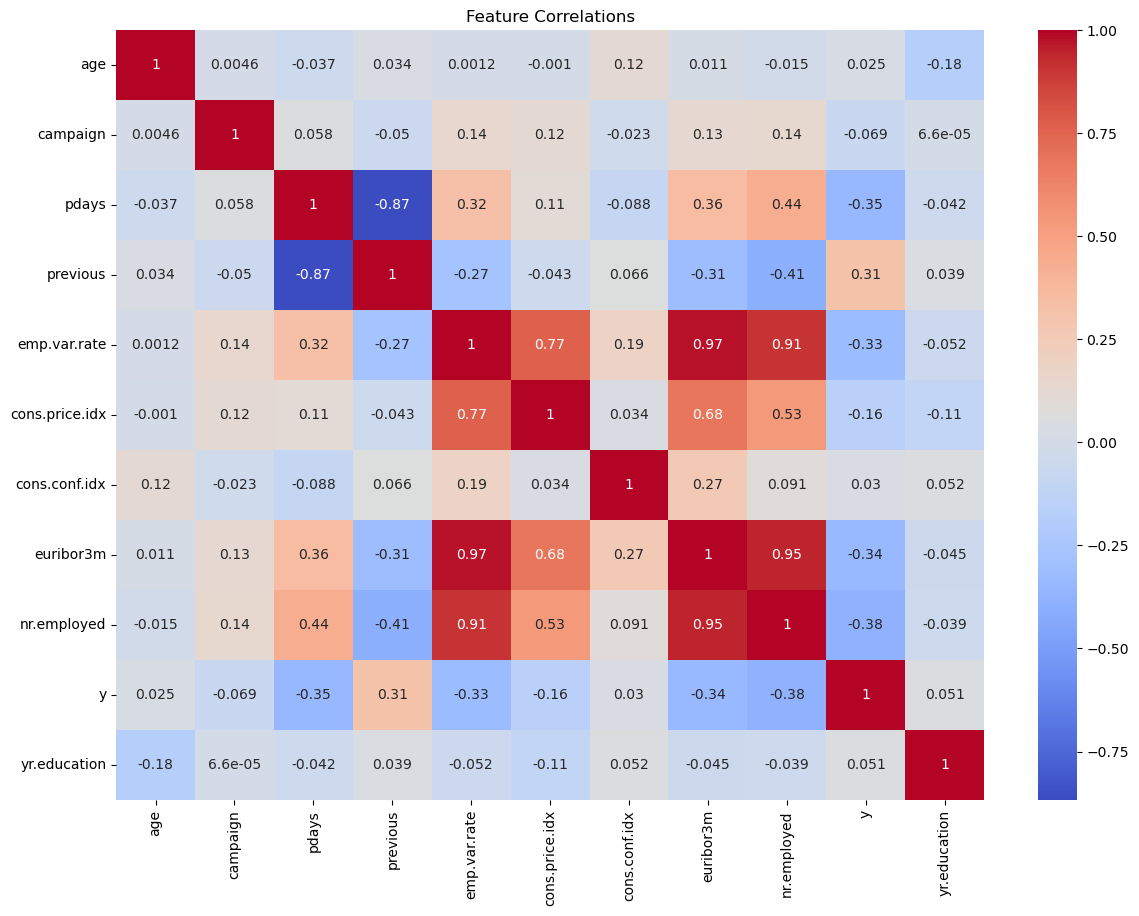

In [84]:
# Correlations of numeric features
if numeric_features := eda.numeric_features():
    plot_data = df[numeric_features]
    plt.figure(figsize=(14, 10))
    plt.title("Feature Correlations", loc='center')
    sns.heatmap(plot_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.savefig("images/heatmap_correlations.png", bbox_inches='tight')
    plt.show() 

### Colinearity Mitigation

#### Drop the `euribor3m` and  `emp.var.rate`  Columns
- 'euribor3m' has very strong correlations with 'emp.var.rate' (0.97), 'nr.employed' (0.95), and 'cons.conf.idx' (0.69). Dropping it breaks off two strongly correlated pairs of features.
- 'emp.var.rate' has very strong correlations with 'euribor3m' (0.97), 'nr.employed' (0.91), and 'cons.price.idx' (0.78). Dropping it breaks off the next strongest correlated pairs.

In [85]:
command = "df.drop(columns=['emp.var.rate', 'nr.employed'], inplace=True)"
eda.before_after_exec(command, 'df')

Dataset shape changed: (37066, 20) -> (37066, 18)


#### The `pdays` Column Has Artifiical Outliers
The `pdays` column, days from the previous call with the customer, is set to 999 if the customer has never been called. This creates artifical data outliers and skews the distribution of the actual values.

In [86]:
df.pdays.value_counts(normalize=True)

999    0.959127
3      0.011844
6      0.011115
4      0.003184
9      0.001727
2      0.001646
7      0.001619
12     0.001565
10     0.001403
5      0.001241
13     0.000971
11     0.000755
1      0.000701
15     0.000647
14     0.000540
8      0.000486
0      0.000405
16     0.000297
17     0.000216
18     0.000189
22     0.000081
19     0.000081
21     0.000054
25     0.000027
26     0.000027
27     0.000027
20     0.000027
Name: pdays, dtype: float64

#### Review Correlations After Columns are dropped

['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'y', 'yr.education']


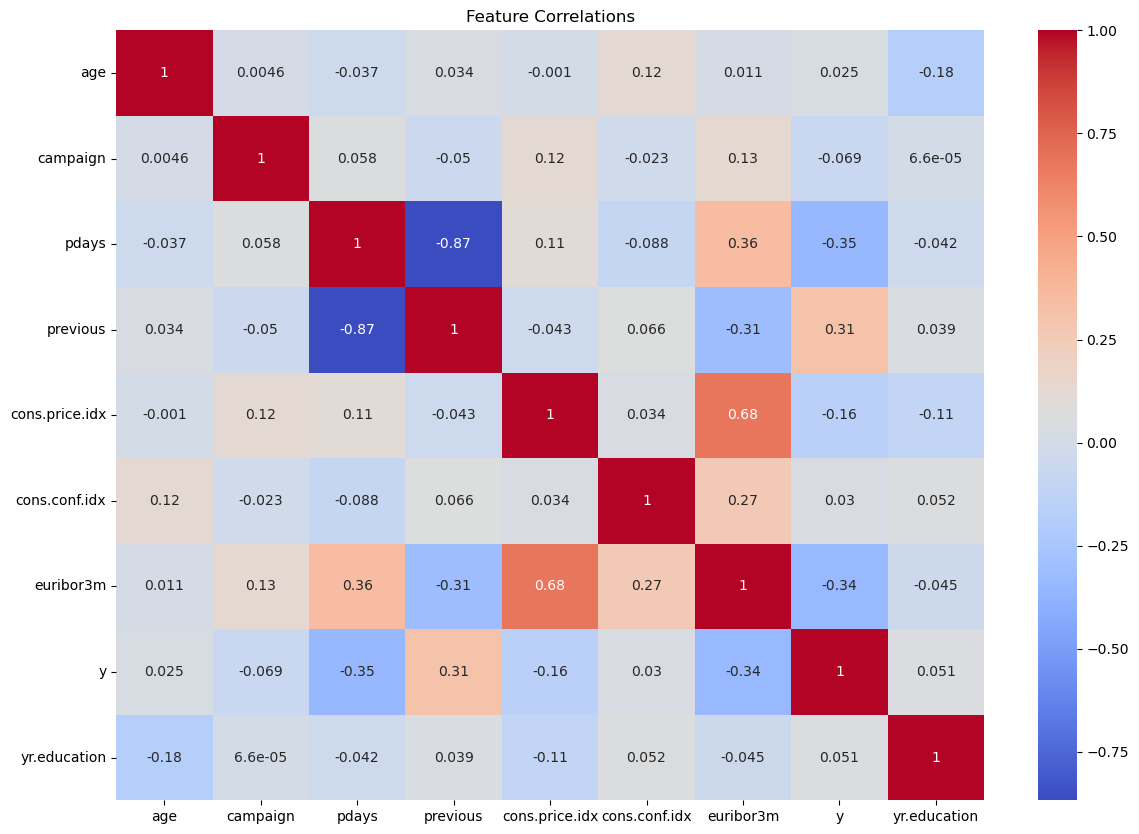

In [87]:
# Correlations of numeric features
if numeric_features := eda.numeric_features():
    print(numeric_features)
    plot_data = df[numeric_features]
    plt.figure(figsize=(14, 10))
    plt.title("Feature Correlations", loc='center')
    sns.heatmap(plot_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
    plt.savefig("images/heatmap_correlations_revisit.png", bbox_inches='tight')
    plt.show() 

#### Separate `pdays=999` as the holdout dataset as 'unseen' data
- Drop the column after the separation

Holdout set as percentage of total observations: 95.91

Holdout Set: (35551, 17)
X: (1515, 16)
y: (1515,)

Target class distribution:
 1    967
0    548
Name: y, dtype: int64


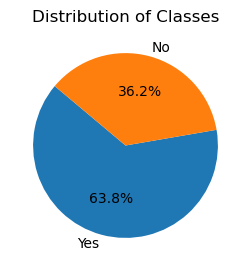

In [88]:
holdout_mask = (df['pdays'] == 999)
print(f"Holdout set as percentage of total observations: {100 * holdout_mask.sum()/df.shape[0]:.2f}\n")
holdout_idx = df[holdout_mask].index
X_holdout = df[df.index.isin(holdout_idx)].drop(columns = ['y'])
y_holdout = df[df.index.isin(holdout_idx)]['y']
# Exclude the holdout set from X
X = df[~df.index.isin(holdout_idx)].drop(columns=['y'])
X.drop(columns=['pdays'], inplace=True)

# Exclude the 'y' values from y
y = df[~df.index.isin(holdout_idx)]['y']

print(f"Holdout Set: {X_holdout.shape}")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print("\nTarget class distribution:\n", y.value_counts())

# Creating the pie chart
labels = y.map({0: 'No', 1: 'Yes'})
value_counts = labels.value_counts()
plt.figure(figsize=(3, 3))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.savefig('images/dist_imbalanced_classes.png', bbox_inches='tight')
plt.show()


In [89]:
command = "df.drop(columns=['pdays'], inplace=True)"
eda.before_after_exec(command, 'df')

Dataset shape changed: (37066, 18) -> (37066, 17)


|| [Data Dictinoary](#dictionary) ||
[Data Exploration](#explore_data) || [Preprocessing & Transformation](#transform_data) ||
[Modeling](#model) ||

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    stratify=y,
                                                    random_state=22) #7 best

<a id="features"></a>
### Categorical Feature Selection for Dimensionality Reduction

In [91]:
# !pip install lightgbm

X: (1515, 16)       y:(1515,)
X_train: (1060, 16) y_train(1060,)
X_test: (455, 16)   y_test(455,)


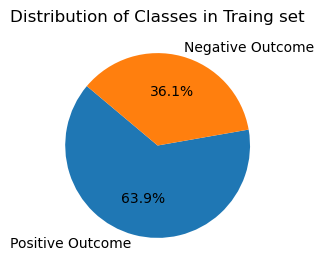

In [92]:
print(f"X: {X.shape}       y:{y.shape}")
print(f"X_train: {X_train.shape} y_train{y_train.shape}")
print(f"X_test: {X_test.shape}   y_test{y_test.shape}")
# Creating the pie chart
labels = y_train.map({0: 'Negative Outcome', 1: 'Positive Outcome'})
value_counts = labels.value_counts()
plt.figure(figsize=(3, 3))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes in Traing set')
plt.savefig('images/dist_imbalanced_classes.png', bbox_inches='tight')
plt.show()


In [93]:
X.columns

Index(['age', 'job', 'marital', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'yr.education'],
      dtype='object')

In [94]:
new_column_names = {'age': 'Age', 
             'job': 'Occupation',
             'default': 'Default',       
             'marital': 'Marital Status',
             'housing': 'Mortgage',
             'loan': 'Loan',
             'month': 'Month',
             'day_of_week': 'Day of Week',
             'campaign': 'Num. of Calls',
             'previous': 'Num. of Past Calls',
             'poutcome': 'Previous Outcome',
             'cons.price.idx': 'Consumer Price Index',
             'cons.conf.idx': 'Consumer Confident Index',
             'nr.employed': 'Num. of Employees',
             'yr.education': 'Years of Education',
             'euribor3m': 'EURIBOR'}
X.rename(new_column_names, axis=1, inplace=True)
X_train.rename(new_column_names, axis=1, inplace=True)
X_test.rename(new_column_names, axis=1, inplace=True)
X_holdout.rename(new_column_names, axis=1, inplace=True)

|| [Data Dictinoary](#dictionary) ||
[Feature Selection](#features) ||
[Modeling](#model) ||
[Model Evaluation](#metrics) ||
[Model Predictions](#predictions) ||

### Use `LightGBM` as a feature selection tool
* To drop low importance features to reduce dimenstionality as many One-hot encoding is expected.
* It works well with categorical features natively and feature selection and importance can be obtained easily
* Eliminate the effort to encode low importance categorical features that increase the dimensionality

In [96]:
import lightgbm as lgb
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Limit X_train and X_test to categorical features only
X_train_selector = X_train[categorical_features]
X_test_selector = X_test[categorical_features]

train_data = lgb.Dataset(X_train_selector, label=y_train, 
                         categorical_feature=categorical_features)
val_data = lgb.Dataset(X_test_selector, label=y_test, reference=train_data)

param = {'is_unbalance': True, 'objective': 'binary', 'num_leaves': 31, 
         'min_data_in_leaf': 10, 'max_depth': 5,
         'lambda_l1': 0.05,
        }
num_round = 5
gbm = lgb.train(param, train_data, num_round)
# gbm = lgb.train(param, train_data, num_round, valid_sets=[val_data], early_stopping_rounds=50)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 677, number of negative: 383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 1060, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638679 -> initscore=0.569636
[LightGBM] [Info] Start training from score 0.569636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [97]:
# Use split count as the measure of feature importance
feature_importance = gbm.feature_importance(importance_type='gain')
feature_names = gbm.feature_name()
importance = list(zip(feature_names, feature_importance))
importance = sorted(importance, key=lambda x: x[1], reverse=True)
features_by_importance = []
for feature_name, importance_score in importance:
    features_by_importance.append(feature_name)
    print(f'{feature_name}: {importance_score:.2f}')

Month: 152.04
Marital_Status: 84.18
Loan: 52.52
Previous_Outcome: 46.95
Occupation: 36.78
Day_of_Week: 34.01
Mortgage: 27.50
contact: 21.10
Default: 5.91


Minimum number of features to exceed 0.85 cumulative gain: 6


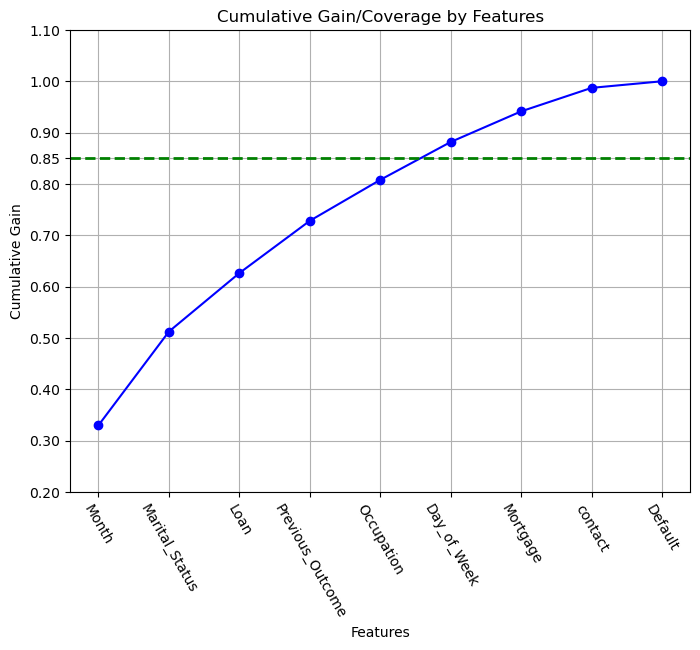

In [98]:
cumulative_gain_threshold = 0.85

# Extract just the importance scores and sort them in descending order
importance_scores = [score for _, score in importance]
# Calculate the cumulative sum of the importance scores
cumulative_importance = np.cumsum(importance_scores)
# Normalize the cumulative importance to have a total of 1
total_importance = cumulative_importance[-1]
cumulative_importance_normalized = cumulative_importance / total_importance

# Find the index where the cumulative importance exceeds threshold
num_features = np.where(cumulative_importance_normalized >= cumulative_gain_threshold)[0][0] + 1
print(f"Minimum number of features to exceed {cumulative_gain_threshold} cumulative gain: {num_features}")

# Plot cumulative gains by features from most important to least
plt.figure(figsize=(8, 6))
plt.plot(features_by_importance, cumulative_importance_normalized, color='blue', marker='o', label='Cumulative Gain')
plt.scatter(features_by_importance, cumulative_importance_normalized, color='red', s=10)
plt.axhline(y=cumulative_gain_threshold, color='green', linestyle='--', linewidth=2)

# Add a ytick for the threshold
current_yticks = plt.yticks()[0]
new_yticks = sorted(list(current_yticks) + [cumulative_gain_threshold])

plt.yticks(new_yticks)
plt.xticks(rotation=-60)
plt.title('Cumulative Gain/Coverage by Features')
plt.xlabel('Features')
plt.ylabel('Cumulative Gain')
plt.grid(True)
plt.savefig('images/gbm_cumulative_gain_by_features.png', bbox_inches='tight')
plt.show()

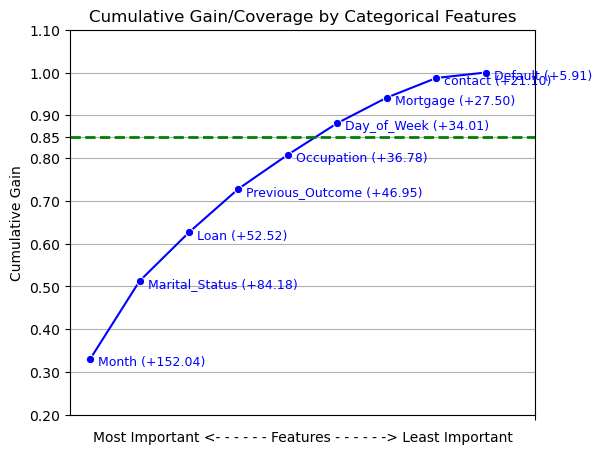

In [99]:
cumulative_gain_threshold = 0.85

# Convert to DataFrame for easier manipulation
df_importance = pd.DataFrame(importance, columns=['feature', 'importance'])

# Calculate Cumulative Gain
df_importance['cumulative_gain'] = df_importance['importance'].cumsum()
df_importance['cumulative_gain'] = df_importance['cumulative_gain'] / df_importance['importance'].sum()

# Create the line plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x='feature', y='cumulative_gain', data=df_importance, color='red', s=10)
sns.lineplot(x='feature', y='cumulative_gain', data=df_importance, sort=False, color='blue', marker='o')
# Annotations
for i, row in df_importance.iterrows():   
    annotation_text = f"  {row['feature']} (+{row['importance']:.2f})"
    x_offset = 0.8
    y_offset = 0.008
    plt.text(row['feature'], row['cumulative_gain'] + y_offset, annotation_text,
             fontsize=9, ha='left', va='top', color='b')

plt.axhline(y=cumulative_gain_threshold, color='green', linestyle='--', linewidth=2)

# Get current yticks
current_yticks = plt.yticks()[0]
# Add a ytick at the shreshold point
new_yticks = sorted(list(current_yticks) + [cumulative_gain_threshold])

plt.yticks(new_yticks)
plt.xticks('')
plt.title('Cumulative Gain/Coverage by Categorical Features')
plt.xlabel('Most Important <- - - - - - Features - - - - - -> Least Important')
plt.ylabel('Cumulative Gain')
plt.grid(True) 
plt.savefig("images/gbm_feature_selection.png", bbox_inches='tight')
plt.show()

In [100]:
# Drop the least important features from the dataset
low_importance_features = features_by_importance[num_features:]
# Drop feaatures from both the training and testing datasets
X.drop(columns=low_importance_features, inplace=True)
X_train.drop(columns=low_importance_features, inplace=True)
X_test.drop(columns=low_importance_features, inplace=True)
X_holdout.drop(columns=low_importance_features, inplace=True)

print('Low importance Features dropped:\n', low_importance_features)

Low importance Features dropped:
 ['Mortgage', 'contact', 'Default']


In [101]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1515 entries, 24108 to 41182
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1515 non-null   int64   
 1   Occupation                1515 non-null   category
 2   Marital Status            1515 non-null   category
 3   Loan                      1515 non-null   category
 4   Month                     1515 non-null   category
 5   Day of Week               1515 non-null   category
 6   Num. of Calls             1515 non-null   int64   
 7   Num. of Past Calls        1515 non-null   int64   
 8   Previous Outcome          1515 non-null   category
 9   Consumer Price Index      1515 non-null   float64 
 10  Consumer Confident Index  1515 non-null   float64 
 11  EURIBOR                   1515 non-null   float64 
 12  Years of Education        1515 non-null   float64 
dtypes: category(6), float64(4), int64(3)
memory

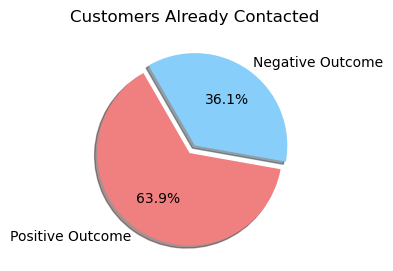

Positive Outcome    677
Negative Outcome    383
Name: y, dtype: int64


In [102]:
# Creating the pie chart
value_counts = labels.value_counts()

labels = y_train.map({0: 'Negative Outcome', 1: 'Positive Outcome'})
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the 1st slice for emphasis

plt.figure(figsize=(3, 3))
plt.pie(value_counts, explode=explode, labels=value_counts.index, colors=colors, shadow=True, autopct='%1.1f%%', startangle=120)
plt.title('Customers Already Contacted')
plt.savefig('images/post_gbm_imbalanced_classes.png', bbox_inches='tight')
plt.show()
print(value_counts)

|| [Data Dictinoary](#dictionary) ||
[Feature Selection](#features) ||
[Modeling](#model) ||
[Model Evaluation](#metrics) ||
[Predictions](#predictions) ||

<a id="model"></a>
## Modeling

In [103]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

import gc
import time

# Define the preprocessing for numeric features: scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Define the preprocessing for categorical features: one-hot encoding
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in X.columns if col not in categorical_features]),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Initialize models to be evaluated
models = {
    'Dummy': DummyClassifier(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVC': SVC(probability=True)
}

# Define hyperparameters for each grid search. 
# The named step in the pipleline is assumed to be 'clf'
param_grids = {
    'Dummy': {'clf__strategy': ['most_frequent']},
    'KNN': {'clf__n_neighbors': range(501, 1505, 50), 
            'clf__weights': ['uniform', 'distance']
           },
    'Decision Tree': {'clf__criterion': ['gini', 'entropy', 'log_loss'],
                      'clf__min_impurity_decrease': [0.01, 0.1, 0],
                      'clf__max_depth': [2, 3, 4], 
                      'clf__min_samples_split': range(50, 100, 5),
                      'clf__ccp_alpha': [0.1, 0, 0.1],
                      'clf__class_weight': [None,'balanced']
                     },
    'Logistic Regression': {'clf__penalty': ['l2'],
                            'clf__C': [0.01,0.05, 0.1, 1],
                            'clf__class_weight': [None,'balanced'],
                            'clf__random_state': [42],
                           },
    'SVC': {'clf__C': [0.1, 1, 2, 3], 
            'clf__gamma': [0.01, 0.05, 0.075],
            'clf__kernel': ['poly', 'rbf'], 
            'clf__degree': [2, 3, 4],
            'clf__coef0': [1],
            'clf__class_weight': [None, 'balanced'],
            'clf__random_state': [42],
           }
    }

# Initialize result dictionary
res_dict = {'Classifier': [],
            'Train score': [], 
            'Test score': [], 
            'Fit time': [],
            'Avg. evaluation time': [],
           }
best_models = []

# Grid Search on each model
# Define the StratifiedKFold strategy to address imbalanced classes
stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for name, model in models.items():
    # Some models are sensitive to scales
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clf', model)
                              ])
    # Construct the Grid search
    grid_search = GridSearchCV(pipeline, param_grids[name], 
                               scoring='f1', 
                               cv=stratified_kfold, n_jobs=8)
    # Forcing a garbage collection
    gc.collect()    

    start_time = time.time()
    grid_search.fit(X, y)
    grid_search_time = time.time() - start_time
    
    # Fit the best model
    model = grid_search.best_estimator_
    best_models.append(model)
#     start_time = time.time()
#     model.fit(X_train, y_train)
#     fit_time = time.time() - start_time
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    res_dict['Classifier'].append(name)
    res_dict['Train score'].append(train_score)
    res_dict['Test score'].append(test_score)
    res_dict['Fit time'].append(grid_search_time)
    res_dict['Avg. evaluation time'].append(grid_search_time/len(grid_search.cv_results_['params']))
    print(grid_search.best_estimator_.named_steps['clf'])

results = pd.DataFrame(res_dict).set_index('Classifier')
results

DummyClassifier(strategy='most_frequent')


C:\Users\rashm\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.77920988 0.78076468 0.77920988 0.77935191 0.77920988 0.77840472
 0.77920988 0.77808928 0.77920988 0.77808928 0.77920988 0.77777208
 0.77920988 0.77777208 0.77920988 0.77777208 0.77920988 0.77777208
 0.77920988 0.77777208 0.77920988 0.77777208 0.77920988 0.77777208
 0.77920988 0.77777208        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


KNeighborsClassifier(n_neighbors=501, weights='distance')
DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_impurity_decrease=0,
                       min_samples_split=70)
LogisticRegression(C=0.01, max_iter=2000, random_state=42)
SVC(C=0.1, coef0=1, gamma=0.075, kernel='poly', probability=True,
    random_state=42)


,Train score,Test score,Fit time,Avg. evaluation time
Classifier,,,,
Dummy,0.638679,0.637363,1.278480,1.278480
KNN,0.994340,0.995604,2.441846,0.058139
Decision Tree,0.716981,0.718681,20.070676,0.012389
Logistic Regression,0.684906,0.701099,0.188816,0.023602
SVC,0.717925,0.705495,35.969778,0.249790


[Modeling](#model) ||
[Model Evaluation](#metrics) ||<br> 
Predictions & Feature Importance:
[KNN](#knn) | [Decision Tree](#decision_tree) | [Logistic Regression](#logistic_regression) | [SVM](#svm)


<a id='metrics'></a>
### Model Performance Metrics

In [104]:
from sklearn.metrics import classification_report
for i in range(1, len(best_models)): # Dummy classifier excluded
    model = best_models[i]
    print(model.named_steps['clf'])
    clf_report = classification_report(y_test, model.predict(X_test), 
                                       target_names=['Negative Outcome', 'Positive Outcome'], 
                                       zero_division=0, output_dict=True, digits=4)

    # Convert the report dictionary to a DataFrame
    df_report = pd.DataFrame(clf_report).transpose()

    # Correct the column for 'accuracy' since it doesn't have the same structure as others
    df_report.loc['accuracy', 'precision':'support'] = ['', '', '', clf_report['accuracy']]

    print(df_report)
    print('\n')

KNeighborsClassifier(n_neighbors=501, weights='distance')
                 precision    recall  f1-score     support
Negative Outcome  0.988024       1.0  0.993976  165.000000
Positive Outcome       1.0  0.993103   0.99654  290.000000
accuracy                                          0.995604
macro avg         0.994012  0.996552  0.995258  455.000000
weighted avg      0.995657  0.995604   0.99561  455.000000


DecisionTreeClassifier(ccp_alpha=0, max_depth=4, min_impurity_decrease=0,
                       min_samples_split=70)
                 precision    recall  f1-score     support
Negative Outcome   0.67619  0.430303  0.525926  165.000000
Positive Outcome  0.731429  0.882759       0.8  290.000000
accuracy                                          0.718681
macro avg          0.70381  0.656531  0.662963  455.000000
weighted avg      0.711397  0.718681  0.700611  455.000000


LogisticRegression(C=0.01, max_iter=2000, random_state=42)
                 precision    recall  f1-score     s

In [105]:
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, auc

def plot_classifier_predictions(model, new_data, baseline=None):
    # Given a fitted model and new data, plot the predictions & probabilities
    predicted_proba = model.predict_proba(new_data)
    negative_class_proba = predicted_proba[:, 0]
    positive_class_proba = predicted_proba[:, 1]
    negative_plot_data = negative_class_proba[negative_class_proba > 0.5]
    
#     colors = ['lightcoral', 'lightskyblue']

    counts, bins, patches = plt.hist(negative_plot_data, bins=10, alpha=0.7, color='lightskyblue', edgecolor='black', label='Predicted Negative Outcome')
    # Add count annotations to the top of the bars
    for count, bin, patch in zip(counts, bins, patches):
        if count > 0:
            # Coordinates of the bar's center
            x_ = (bin + bins[bins.tolist().index(bin)+1])/2 if bins.tolist().index(bin) + 1 < len(bins) else bin
            y_ = patch.get_height()
            plt.text(x_, y_, f'{int(count)}', ha='center', va='bottom')

    # Histogram for the positive class
    positive_plot_data = positive_class_proba[positive_class_proba > 0.5]
    counts, bins, patches = plt.hist(positive_plot_data, bins=10, alpha=0.7, color='lightcoral', edgecolor='black', label='Predicted Positive Outcome')
    # Add count annotations to the top of the bars
    for count, bin, patch in zip(counts, bins, patches):
        if count > 0:
            # Coordinates of the bar's center
            x_ = (bin + bins[bins.tolist().index(bin)+1])/2 if bins.tolist().index(bin) + 1 < len(bins) else bin
            y_ = patch.get_height()
            plt.text(x_, y_, f'{int(count)}', ha='center', va='bottom')
    if baseline: # Draw baseline probablity
        plt.axvline(x=baseline, color='g', linestyle='--')  # 'r' for red color, '--' for dashed line
        plt.text(baseline,  plt.gca().get_ylim()[1], 'baseline probability' + ' ' * 15, 
                 color='g', rotation=90, ha='right', va='top')
   
    plt.title('Distribution of Predictions & Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Predicted Count')
    plt.xticks(np.linspace(0.5, 1, 11))
    plt.xlim(0.45, 1.05)
    plt.legend()
    

def plot_roc_auc(models, labels, data, target):

    for model, label in zip(models, labels):
        # Predict probabilities for the positive class
        proba = model.predict_proba(data)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(target, proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    
    # Plot the random (chance) line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curves of Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)

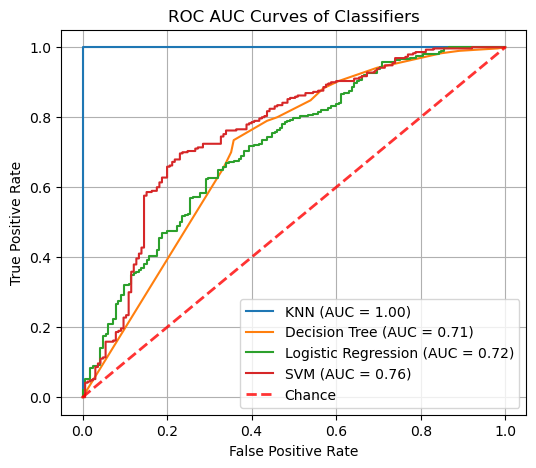

In [106]:
model_labels = ['KNN', 'Decision Tree', 'Logistic Regression', 'SVM']
plt.figure(figsize=(6, 5))
plot_roc_auc(best_models[1:], model_labels, X_test, y_test)
plt.savefig("images/roc_auc.png", bbox_inches='tight')
plt.show()

<a id='predictions'></a>
## Predictions & Feature Importance

[Modeling](#model) ||
[Model Comparison](#metrics) ||<br> 
**[Predictions & Feature Importance](#predictions):**
[KNN](#knn) | [Decision Tree](#decision_tree) | [Logistic Regression](#logistic_regression) | [SVM](#svm)


<a id='knn'></a>
#### Predictions by KNN Classifier

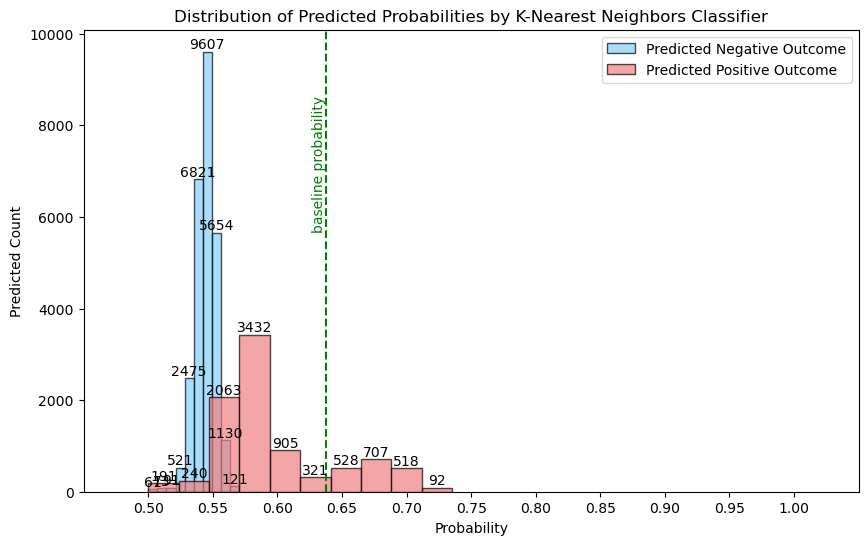

In [107]:
knn_pipeline = best_models[1] # KNN
baseline = 0.638
# Plotting
plt.figure(figsize=(10, 6))
plot_classifier_predictions(knn_pipeline, X_holdout, baseline)
plt.title("Distribution of Predicted Probabilities by K-Nearest Neighbors Classifier")
plt.savefig('images/knn_pred_proba.png', bbox_inches='tight')
plt.show()
# print(knn_pipeline.predict_proba(X_holdout))

#### Obervations
 - Despites KNN has the best "accuracy" score, it mostly predicts the classes with probablilities lower than the baseline probability

[Modeling](#model) ||
[Model Comparison](#metrics) ||<br> 
**Predictions & Feature Importance:**
[KNN](#knn) | [Decision Tree](#decision_tree) | [Logistic Regression](#logistic_regression) | [SVM](#svm)


<a id='decision_tree'></a>
#### Decision Tree Classifier - Predictions and Feature Importance

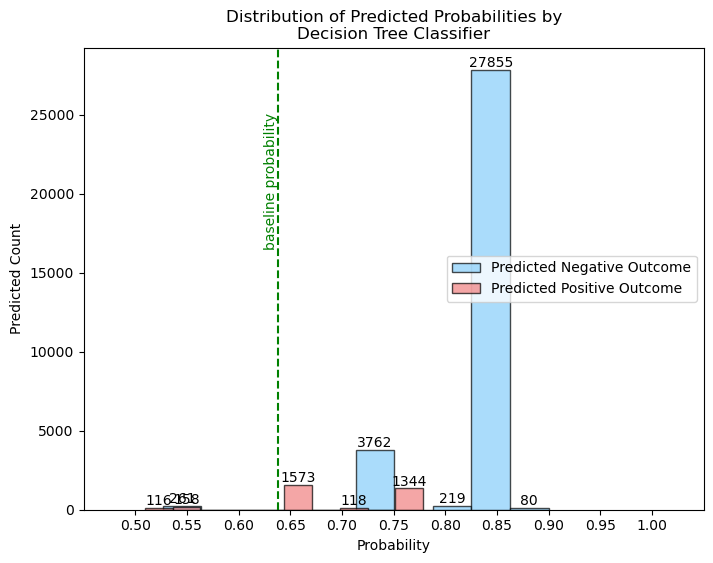

In [108]:
dtc_pipeline = best_models[2] # Decision Tree
# Plotting
baseline = 0.638
plt.figure(figsize=(8, 6))
plot_classifier_predictions(dtc_pipeline, X_holdout, baseline)
plt.title("Distribution of Predicted Probabilities by\nDecision Tree Classifier")
plt.legend(loc='center right')
plt.savefig('images/tree_pred_proba.png', bbox_inches='tight')
plt.show()

#### Feature Importance by Decision Tree Classifier

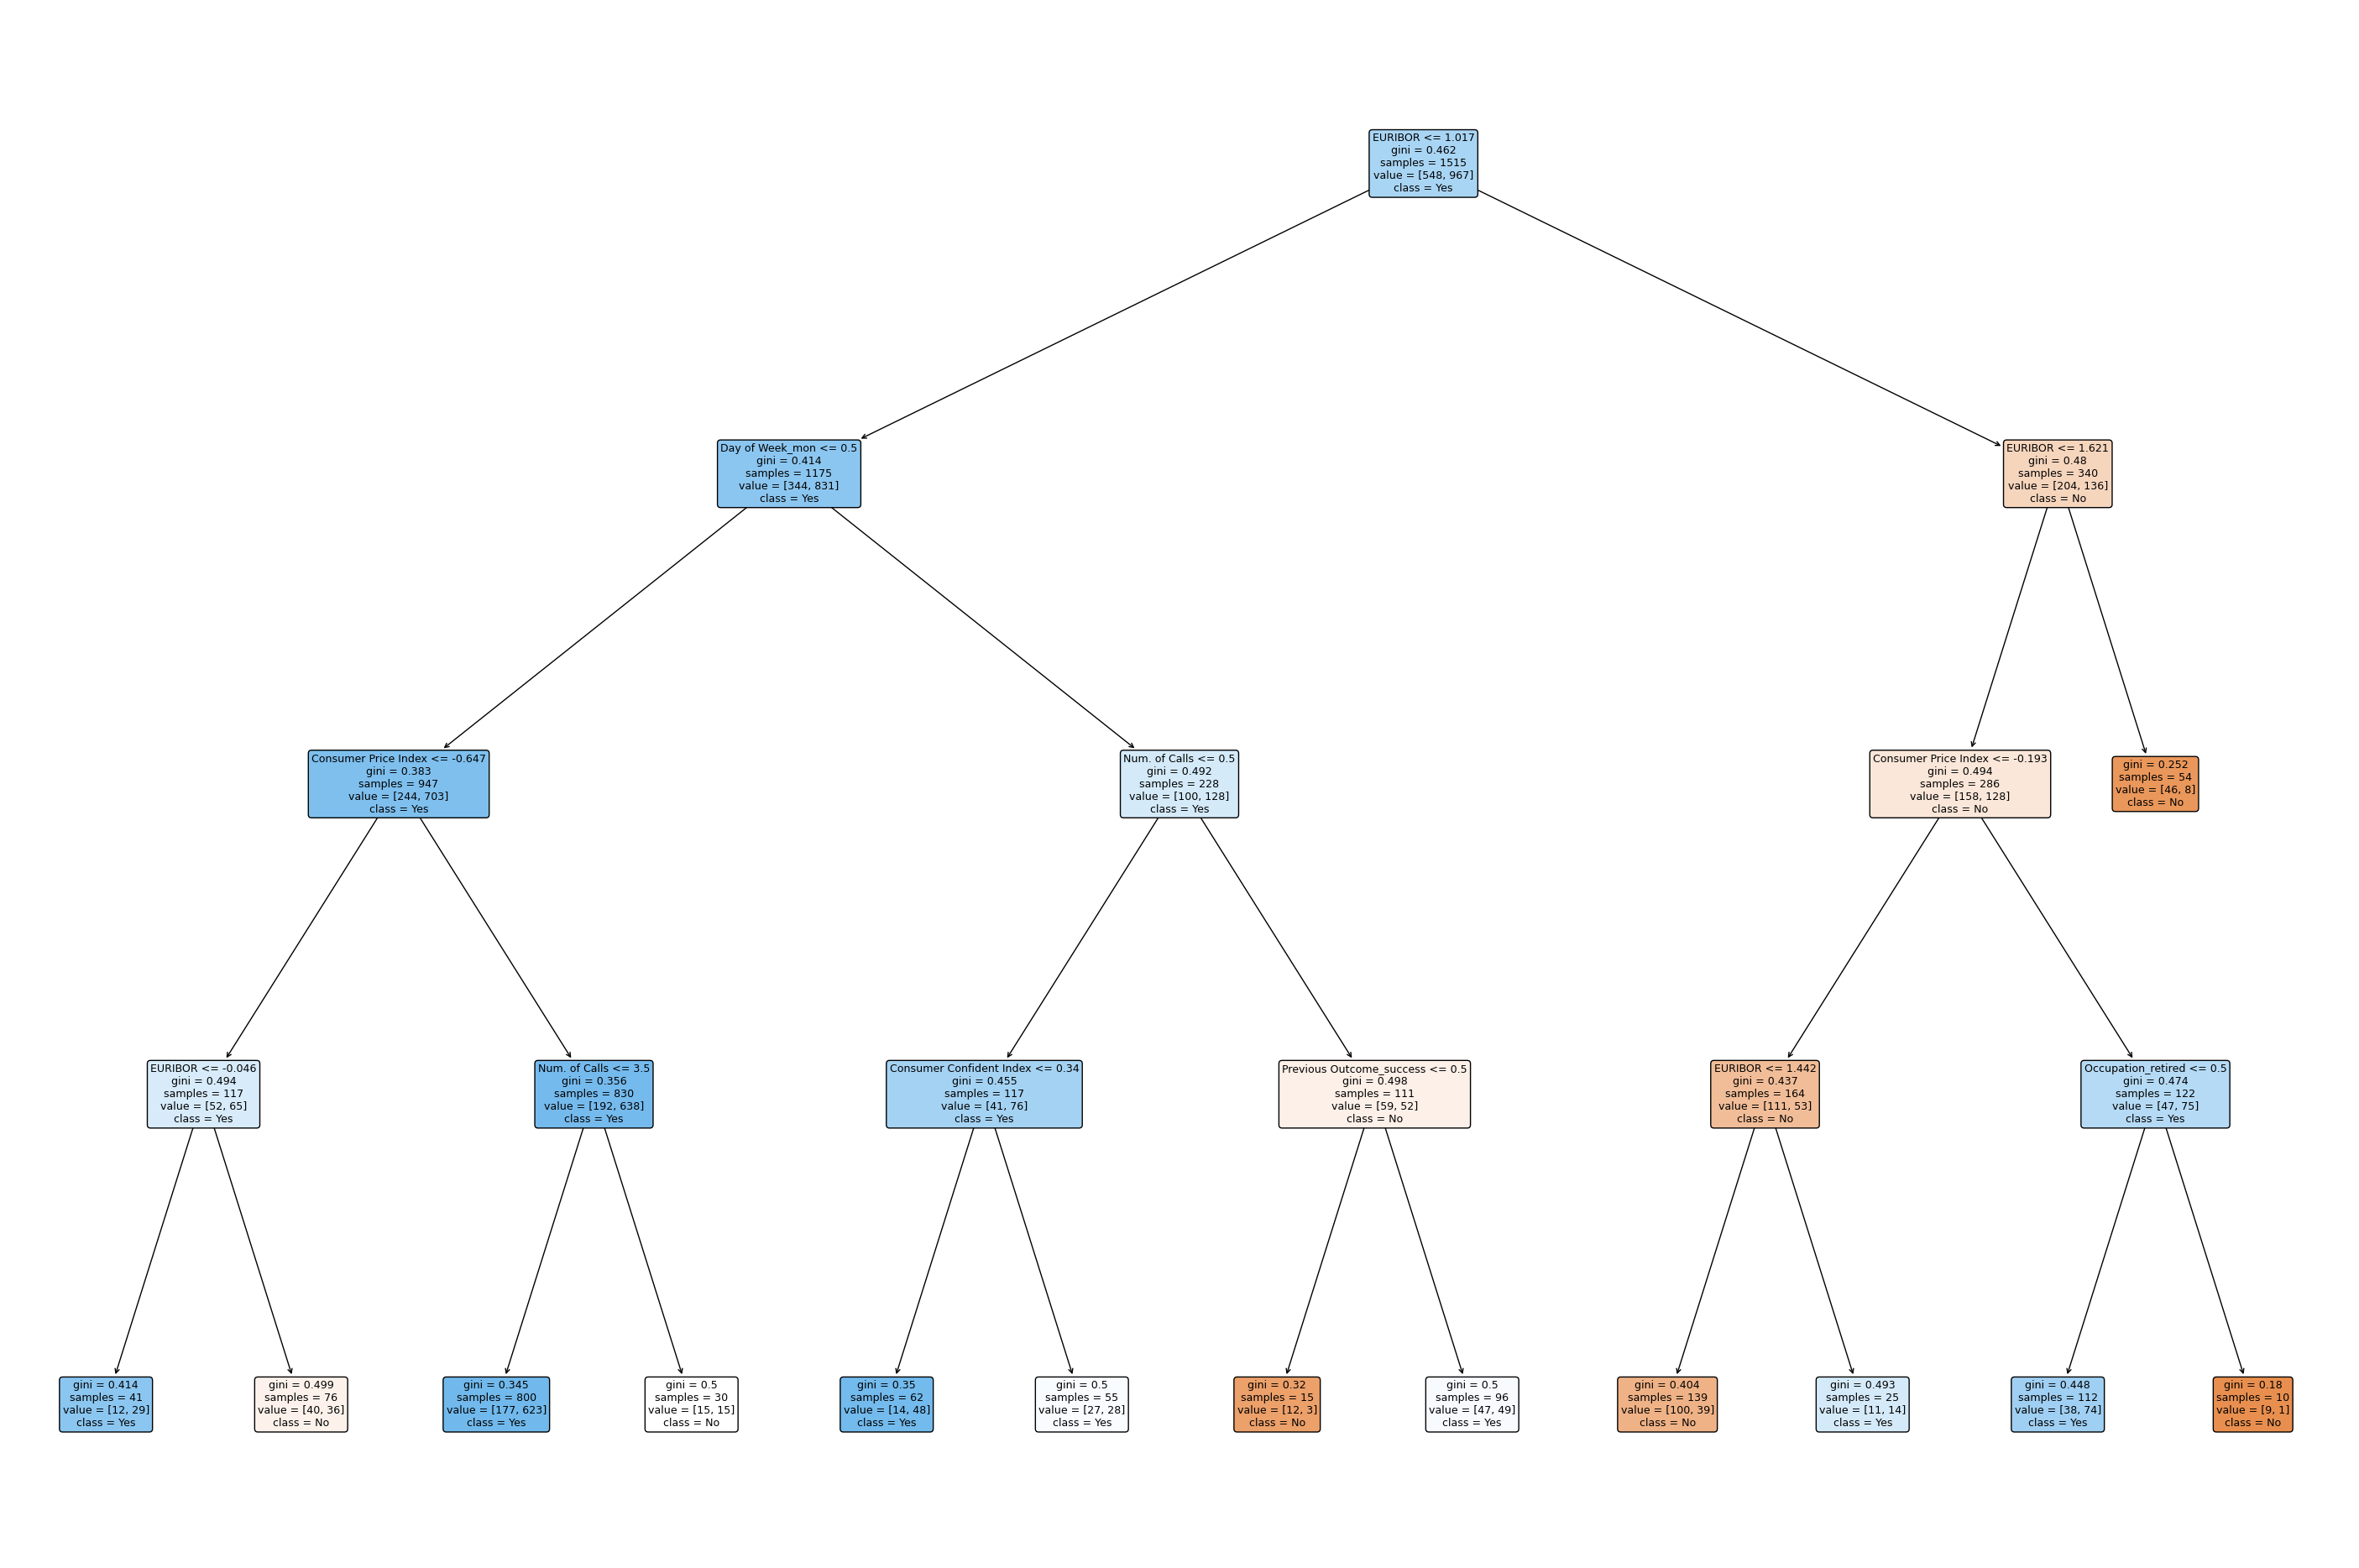

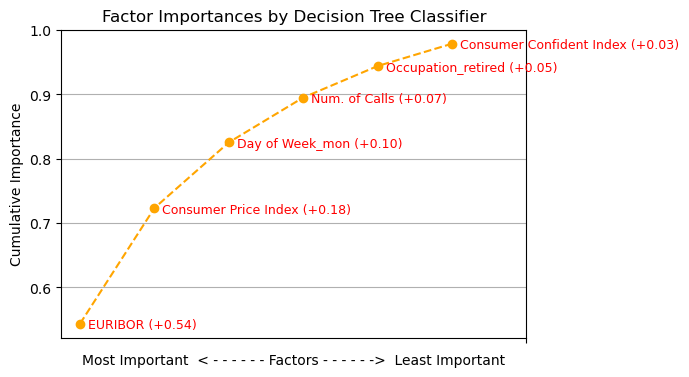

In [109]:
dtc_pipeline = best_models[2] # Decision Tree
preprocessor = dtc_pipeline.named_steps['preprocessor']
clf = dtc_pipeline.named_steps['clf']

# Get cleaned feature names
transformed_feature_names = preprocessor.get_feature_names_out().tolist()
features = [name.split('__')[-1] for name in transformed_feature_names]

# Plot the decision tree
plt.figure(figsize=(36, 24))
plot_tree(clf, filled=True, feature_names=features, class_names=['No', 'Yes'], rounded=True)
plt.savefig("images/best_decision_tree.png", bbox_inches="tight")
plt.show()

# Plot feature importance
plt.figure(figsize=(6, 4))
# Get feature importances
feature_importances = clf.feature_importances_
# Create a DataFrame to display feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# Sort in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Exclude insignificant features
importance_threshold = 0.03
feature_importance_df = feature_importance_df.query("Importance > @importance_threshold")

# Calculate cumulative absolute importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].abs().cumsum()

# Plotting
plt.plot(feature_importance_df['Feature'], feature_importance_df['Cumulative Importance'], 
         marker='o', linestyle='--', color='orange')
plt.scatter(feature_importance_df['Feature'], feature_importance_df['Cumulative Importance'], s=3)

# Annotating each data point with its importance value
for i, row in feature_importance_df.iterrows():   
    annotation_text = f"  {row['Feature']} (+{row['Importance']:.2f})"
    x_offset = 0.8
    y_offset = 0.008
    plt.text(row['Feature'], row['Cumulative Importance'] + y_offset, annotation_text,
             fontsize=9, ha='left', va='top', color='r')
    
plt.title('Factor Importances by Decision Tree Classifier')
plt.xlabel('Most Important  < - - - - - - Factors - - - - - ->  Least Important')
plt.ylabel('Cumulative Importance')
plt.grid(axis='y')
plt.xticks("") 
plt.savefig("images/decision_tree_cum_importance.png", bbox_inches='tight')
plt.show()

[Modeling](#model) ||
[Model Comparison](#metrics) ||<br> 
**Predictions & Feature Importance:**
[KNN](#knn) | [Decision Tree](#decision_tree) | [Logistic Regression](#logistic_regression) | [SVM](#svm)


<a id='logistic_regression'></a>
#### Logistic Regression Classifier - Predictions and Feature Importance

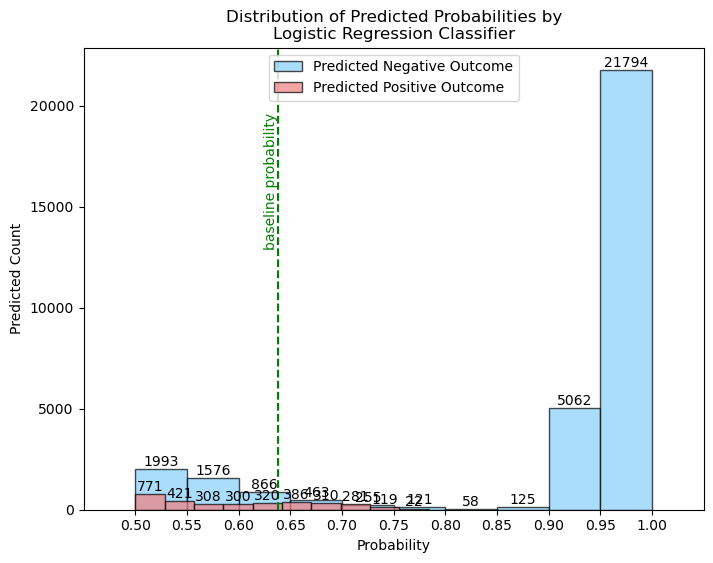

In [110]:
logreg_pipeline = best_models[3] # Logistic Regression Classifier
baseline = 0.638
# Plotting
plt.figure(figsize=(8, 6))
plot_classifier_predictions(logreg_pipeline, X_holdout, baseline)
plt.title("Distribution of Predicted Probabilities by\nLogistic Regression Classifier")
plt.legend(loc='upper center')
plt.savefig('images/logreg_pred_proba.png', bbox_inches='tight')
plt.show()

#### Feature Importance by Logictic Regression Classifier

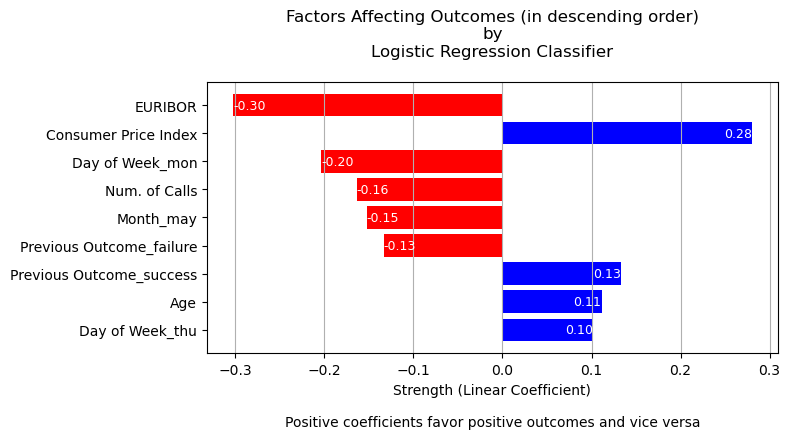

In [111]:
logreg_clf = logreg_pipeline.named_steps['clf']
# Get coefficients from the Logistic Regression model
coefficients = logreg_clf.coef_[0]

# Pair coefficients with cleaned feature names
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort the features by the absolute values of their coefficients in descending order
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Exclude insignificant coefs based on coef_threshold
coef_threshold = 0.1
coef_df_significant = coef_df[coef_df['Coefficient'].abs() >= coef_threshold]
# Reverse the DataFrame to ensure descending order from top to bottom in the plot
coef_df_significant = coef_df_significant.iloc[::-1]

# Plot Horizontal bar chart
plt.figure(figsize=(8, len(coef_df_significant) * 0.5))  # Adjust figure size based on the number of significant features
bars = plt.barh(coef_df_significant['Feature'], coef_df_significant['Coefficient'],
                color=np.where(coef_df_significant['Coefficient'] > 0, 'b', 'r'))

plt.title('Factors Affecting Outcomes (in descending order)\nby\nLogistic Regression Classifier\n')
plt.xlabel('Strength (Linear Coefficient)\n\nPositive coefficients favor positive outcomes and vice versa')
plt.ylabel('')

# Annotate bars with the coefficient values
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}',
             va='center', ha='left' if bar.get_width() < 0 else 'right', color='white', fontsize=9)

plt.grid(axis='x')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig('images/feat_importance_logistic_reg.png')
plt.show()

[Modeling](#model) ||
[Model Evaluation](#metrics) ||<br> 
Predictions & Feature Importance:
[KNN](#knn) | [Decision Tree](#decision_tree) | [Logistic Regression](#logistic_regression) | [SVM](#svm)

<a id='svm'></a>
#### Support Vector Machine Classifier

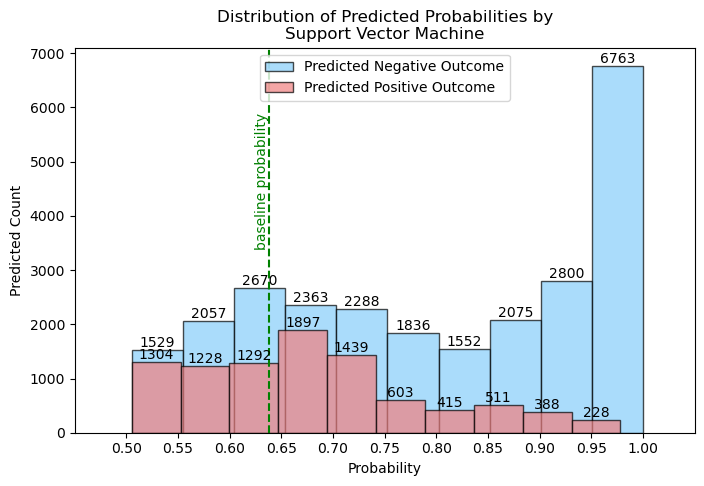

In [112]:
svc_pipeline = best_models[4] # SVC
baseline = 0.638
# Plotting
plt.figure(figsize=(8, 5))
plot_classifier_predictions(svc_pipeline, X_holdout, baseline)
plt.title("Distribution of Predicted Probabilities by\nSupport Vector Machine")
plt.savefig('images/svc_pred_proba.png', bbox_inches='tight')
plt.legend(loc='upper center')
plt.show()

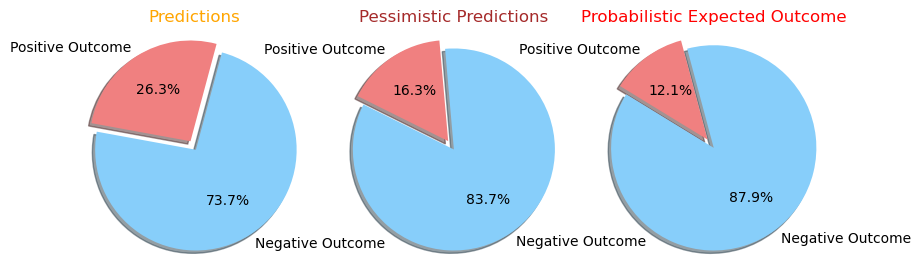

In [114]:
preds = svc_pipeline.predict(X_holdout)
positive_count = preds.sum()
negative_count = X_holdout.shape[0] - positive_count


pred_probas = svc_pipeline.predict_proba(X_holdout)
pessmistic_pos_count =preds.sum()

pessmistic_positive_preds = pred_probas[pred_probas[:, 1] > 0.638]
pessmistic_pos_count = pessmistic_positive_preds.sum()

probablistic_expected_value = pessmistic_positive_preds[:, 1].sum()

# Data to plot
fig, ax = plt.subplots(1, 3, figsize=(9.5, 3))
labels = 'Positive Outcome', 'Negative Outcome'
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the 1st slice for emphasis

# Plot
# plt.figure(figsize=(3, 3))
sizes = [positive_count, negative_count]
ax[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=75)
ax[0].set_title('Predictions', color='orange')
ax[0].axis('equal')

pessmistic_sizes = [pessmistic_pos_count, len(pred_probas) - pessmistic_pos_count]
ax[1].pie(pessmistic_sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=95)
ax[1].set_title('Pessimistic Predictions', color='brown')
ax[1].axis('equal')


probablistic_sizes = [probablistic_expected_value, len(pred_probas) - probablistic_expected_value]
ax[2].pie(probablistic_sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=105)
ax[2].set_title('Probabilistic Expected Outcome', color='red')
ax[2].axis('equal')

plt.savefig("images/svc_predictions.png", bbox_inches='tight')
plt.show()


||[Data Exploration](#explore_data) || 
[Preprocessing & Transformation](#transform_data) ||
[Modeling](#model) ||
[Model Comparision](#metrics) ||

In [115]:
print(len(pred_probas))

35551


In [116]:
print(probablistic_expected_value)

4298.244389282532
